The supervisor module determines whether to route the user’s question to an LLM (Large Language Model) or RAG (Retrieval-Augmented Generation) based on the nature of the query.

 * If the question is general, it is handled directly by the LLM.

 * If the question is related to USA or GDP financial data, it is routed to the RAG system.

Once RAG generates a response, the answer is validated.

 * If RAG is unable to answer or returns insufficient information, the system then falls back to a web search tool to retrieve the necessary data.

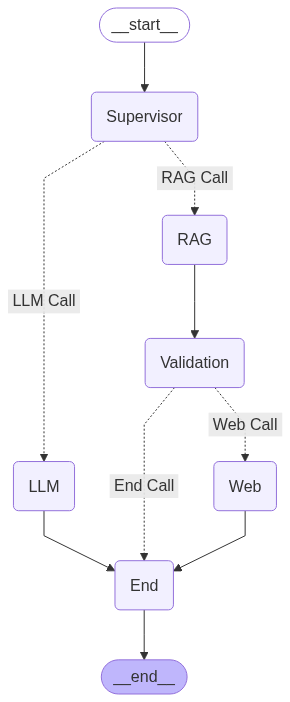

### Load ENV and WebSearch Tool

In [1]:
import os
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
load_dotenv()
WS_TOOL=TavilySearchResults(api_key=os.getenv("TAVILY_API_KEY"), max_results=3)

### LLM and Embedding Model:

In [2]:
# Get LLM
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
MODEL=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
EMBEDDING=HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(EMBEDDING.embed_query("Hi"))

/Users/arindam/Machine Learning/GenAI_2025/AGENTICCLASS/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

### Load & Split Document and Create Vector DB

In [3]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma, FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader=DirectoryLoader(path='Data',glob="./*.txt",loader_cls=TextLoader)

docs=loader.load()

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

split_docs=text_splitter.split_documents(documents=docs)
print("Number of Documents:", len(split_docs))

db=FAISS.from_documents(split_docs,EMBEDDING)
retriever = db.as_retriever(search_kwargs={'k': 4})

Number of Documents: 55


### Pydantic Class and Parser:

In [4]:
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class TopicSelctionParser(BaseModel): #Pydantic class for Supervisor
    Topic:str=Field(description="Selected Topic")
    Reasoning:str=Field(description="Reasoning behind topic selection")
topic_selction_parser=PydanticOutputParser(pydantic_object=TopicSelctionParser)

class ValidateOutputParser(BaseModel): #Pydantic class for RAG
    Validation:str=Field(description="Answer is Valid or Invalid")
    Reasoning:str=Field(description="Validation reason")
validate_output_parser=PydanticOutputParser(pydantic_object=ValidateOutputParser)

### Prompt Templates:

In [5]:
# Prompt Template for Supervisor Node:
supervisor_template="""
    Your task is to classify the given user query into one of the following categories: [USA, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

# RAG Prompt Template:
rag_template="""
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    
    \nQuestion: {question} 
    \nContext: {context} 
    \nAnswer:
    """

# Answer Validation Template:
validation_template="""
    Your task is to classify the given user question and answer into one of the following categories: [Valid, Invalid]. 
    Answer is valid if it directly answers the question without asking to refer external website for exact answer.
    Only respond with the category name and nothing else.

    Question: {question}
    Answer: {answer}
    {format_instructions}
    """

# Web Context prompt Template
web_template="""
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
    Use three sentences maximum to answer the question in concise, add source information if available.
    
    \nQuestion: {question} 
    \nContext: {context} 
    \nAnswer:
    """

### Define AgentState:

In [6]:
import operator
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Supervisor Node:

In [7]:
from langchain_core.prompts import PromptTemplate
def supervisor_fun(state:AgentState):
    
    question=state["messages"][-1]
    
    print("***** Supervisor Node *****")
    print("Question: ",question)
   
    prompt= PromptTemplate(
        template=supervisor_template,
        input_variable=["question"],
        partial_variables={"format_instructions": topic_selction_parser.get_format_instructions()}
    )
    
    chain= prompt | MODEL | topic_selction_parser
    
    response = chain.invoke({"question":question})
    
    print("Response:", response)
    
    return {"messages": [response.Topic]}

### Router Functions:

In [9]:
def sup_router(state:AgentState):

    last_message=state["messages"][-1]
    if "usa" in last_message.lower():
        return "RAG Call"
    else:
        return "LLM Call"

def val_router(state:AgentState):
    
    last_message=state["messages"][-1]
    if "invalid" in last_message.lower():
        return "Web Call"
    else:
       return "End Call"

### LLM Node:

In [10]:
def llm_fun(state:AgentState):
    question=state["messages"][0]
    print("***** LLM Node *****")
    print("Question: ",question)

    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = MODEL.invoke(complete_query)
    print("Response:", response.content)
    return {"messages": [response.content]}

### RAG Node:

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def rag_fun(state:AgentState):
    question=state["messages"][0]
    
    print("***** RAG Node *****")
    print("Question: ",question)

    prompt=PromptTemplate(
    template=rag_template,
    input_variables=['context', 'question']
    )
     
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | MODEL
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    print("Response:", result)
    
    return  {"messages": [result]}

### Validation Node:

In [13]:
def validation_fun(state:AgentState):
    
    question=state["messages"][0]
    answer=state["messages"][-1]
    
    print("***** Validation Node *****")
    print("Question: ",question)
    print("Answer  : ",answer)
   
    prompt= PromptTemplate(
        template=validation_template,
        input_variable=["question", "answer"],
        partial_variables={"format_instructions": validate_output_parser.get_format_instructions()}
    )
    
    chain= prompt | MODEL | validate_output_parser
    
    response = chain.invoke({"question":question, "answer":answer})
    print("Response:", response)
    
    return {"messages": [response.Validation]}

### Web Search Node:

In [14]:
def web_fun(state:AgentState):
    question=state["messages"][0]
    
    print("***** Web Search Node *****")
    print("Question: ",question)

    prompt=PromptTemplate(
    template=web_template,
    input_variables=["context", "question"]
    )
    
    srearch_results=WS_TOOL.run(question)
    context="\n".join([result.get("content", '') for result in srearch_results])

    rag_chain = (
        {"context": RunnableLambda(lambda x:context), "question": RunnablePassthrough()}
        | prompt
        | MODEL
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    print("Response:", result)
    
    return  {"messages": [result]}

### End Node:

In [28]:
def end_fun(state:AgentState):
    print("***** End Node *****")

    print(f"User Question: {state["messages"][0]}")

    last_message=state["messages"][-1]
    if "valid" in last_message.lower():
        print(f"System Answer: {state["messages"][-2]}")
    else:
        print(f"System Answer: {state["messages"][-1]}")

### Define StateGraph:

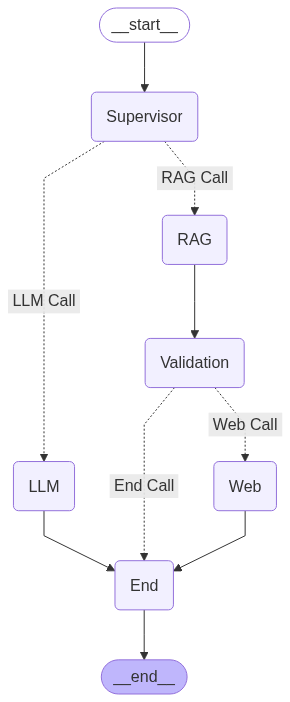

In [35]:
from langgraph.graph import StateGraph, END
workflow=StateGraph(AgentState)

# add nodes:
workflow.add_node("Supervisor", supervisor_fun)
workflow.add_node("LLM", llm_fun)
workflow.add_node("RAG", rag_fun)
workflow.add_node("Validation", validation_fun)
workflow.add_node("Web", web_fun)
workflow.add_node("End", end_fun)

# set entry
workflow.set_entry_point("Supervisor")

# add edges:
workflow.add_conditional_edges("Supervisor", sup_router,
                                                        {
                                                            "RAG Call": "RAG",
                                                            "LLM Call": "LLM",
                                                        })
workflow.add_edge("LLM", "End")
workflow.add_edge("RAG", "Validation")
workflow.add_conditional_edges("Validation", val_router,
                                                        {
                                                            "Web Call": "Web",
                                                            "End Call": "End",
                                                        })
workflow.add_edge("Web", "End")             
workflow.add_edge("End", END)
app=workflow.compile()  
workflow.compile()

### Test APP:

In [31]:
state={"messages": ["Hello"]}
app.invoke(state)

***** Supervisor Node *****
Question:  Hello
Response: Topic='Not Related' Reasoning="The query 'Hello' is a generic greeting and does not relate to the USA."
***** LLM Node *****
Question:  Hello
Response: Hello!
***** End Node *****
User Question: Hello
System Answer: Hello!


{'messages': ['Hello', 'Not Related', 'Hello!']}

In [32]:
state={"messages": ["What is the GDP of USA"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is the GDP of USA
Response: Topic='USA' Reasoning='The query explicitly asks for the GDP of the USA.'
***** RAG Node *****
Question:  What is the GDP of USA
Response: The nominal GDP of the USA is estimated to be around $28 trillion USD as of 2024.  This represents approximately 25% of the global economy.  It holds the #1 ranking worldwide by nominal GDP.
***** Validation Node *****
Question:  What is the GDP of USA
Answer  :  The nominal GDP of the USA is estimated to be around $28 trillion USD as of 2024.  This represents approximately 25% of the global economy.  It holds the #1 ranking worldwide by nominal GDP.
Response: Validation='Valid' Reasoning='The answer provides a direct response to the question about the GDP of the USA without referring to external sources.'
***** End Node *****
User Question: What is the GDP of USA
System Answer: The nominal GDP of the USA is estimated to be around $28 trillion USD as of 2024.  This represents ap

{'messages': ['What is the GDP of USA',
  'USA',
  'The nominal GDP of the USA is estimated to be around $28 trillion USD as of 2024.  This represents approximately 25% of the global economy.  It holds the #1 ranking worldwide by nominal GDP.',
  'Valid']}

In [33]:
state={"messages": ["What is the growth of world's most powerful economy?"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is the growth of world's most powerful economy?
Response: Topic='USA' Reasoning="The world's most powerful economy is generally considered to be the United States' economy."
***** RAG Node *****
Question:  What is the growth of world's most powerful economy?
Response: The U.S. economy, the world's most powerful, has a $28 trillion GDP.  It's considered the engine of global growth due to innovation, financial strength, and strong institutions.  Its continued dominance is anticipated.
***** Validation Node *****
Question:  What is the growth of world's most powerful economy?
Answer  :  The U.S. economy, the world's most powerful, has a $28 trillion GDP.  It's considered the engine of global growth due to innovation, financial strength, and strong institutions.  Its continued dominance is anticipated.
Response: Validation='Valid' Reasoning="The answer directly addresses the question by identifying the world's most powerful economy and providing 

{'messages': ["What is the growth of world's most powerful economy?",
  'USA',
  "The U.S. economy, the world's most powerful, has a $28 trillion GDP.  It's considered the engine of global growth due to innovation, financial strength, and strong institutions.  Its continued dominance is anticipated.",
  'Valid']}

In [34]:
state={"messages": ["What is LLM?"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is LLM?
Response: Topic='Not Related' Reasoning='The query "What is LLM?" is a general question about large language models and not specific to the USA.'
***** LLM Node *****
Question:  What is LLM?
Response: LLM stands for **Large Language Model**.  It's a type of artificial intelligence (AI) that's trained on massive amounts of text data. This allows it to understand, generate, and translate human language.  Think of it as a sophisticated pattern-matching machine that has learned the statistical relationships between words and phrases.  Examples of LLMs include GPT-3 (and its successors like GPT-4), LaMDA, and PaLM.  They power many applications, from chatbots and text summarization to machine translation and code generation.
***** End Node *****
User Question: What is LLM?
System Answer: LLM stands for **Large Language Model**.  It's a type of artificial intelligence (AI) that's trained on massive amounts of text data. This allows it to un

{'messages': ['What is LLM?',
  'Not Related',
  "LLM stands for **Large Language Model**.  It's a type of artificial intelligence (AI) that's trained on massive amounts of text data. This allows it to understand, generate, and translate human language.  Think of it as a sophisticated pattern-matching machine that has learned the statistical relationships between words and phrases.  Examples of LLMs include GPT-3 (and its successors like GPT-4), LaMDA, and PaLM.  They power many applications, from chatbots and text summarization to machine translation and code generation."]}

In [25]:
state={"messages": ["What is GDP?"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is GDP?
Response: Topic='Not Related' Reasoning="The query 'What is GDP?' is a general economic question not specific to the USA."
***** LLM Node *****
Question:  What is GDP?
Response: GDP, or Gross Domestic Product, is the total monetary or market value of all the finished goods and services produced within a country's borders in a specific time period.  It's a key indicator of a country's economic health and size.  GDP is usually calculated on an annual or quarterly basis.  There are different ways to calculate GDP (expenditure approach, income approach, production approach), but they all aim to measure the same thing: the total value of economic activity within a country.
***** End Node *****
User: What is GDP?
System: GDP, or Gross Domestic Product, is the total monetary or market value of all the finished goods and services produced within a country's borders in a specific time period.  It's a key indicator of a country's economic healt

{'messages': ['What is GDP?',
  'Not Related',
  "GDP, or Gross Domestic Product, is the total monetary or market value of all the finished goods and services produced within a country's borders in a specific time period.  It's a key indicator of a country's economic health and size.  GDP is usually calculated on an annual or quarterly basis.  There are different ways to calculate GDP (expenditure approach, income approach, production approach), but they all aim to measure the same thing: the total value of economic activity within a country."]}

In [ ]:
state={"messages": ["What is the longest road in USA"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is the longest road in USA
Response: Topic='USA' Reasoning='The query explicitly asks about the longest road in the USA.'
***** RAG Node *****
Question:  What is the longest road in USA
Response: I don't know.  The provided text is about the U.S. economy and doesn't contain information about roads.
***** Validation Node *****
Question:  What is the longest road in USA
Answer  :  I don't know.  The provided text is about the U.S. economy and doesn't contain information about roads.
Response: Validation='Invalid' Reasoning='The answer does not provide the information requested; instead, it indicates a lack of knowledge.'
***** Web Search Node *****
Question:  What is the longest road in USA
Response: Interstate 90 is currently the longest road in the US, measuring 3,101.77 miles.  US Route 20 previously held the title at 3,365 miles but has since been surpassed.  Sources vary on the exact current length of I-90.
***** End Node *****
User: What 

{'messages': ['What is the longest road in USA',
  'USA',
  "I don't know.  The provided text is about the U.S. economy and doesn't contain information about roads.",
  'Invalid',
  'Interstate 90 is currently the longest road in the US, measuring 3,101.77 miles.  US Route 20 previously held the title at 3,365 miles but has since been surpassed.  Sources vary on the exact current length of I-90.']}